In [19]:
# Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text cleaning
import re
import string
#import emoji
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

# Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from langdetect import detect, LangDetectException
import contractions
from nltk.tokenize import word_tokenize

# Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

# PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec

# Transformers library for BERT
import transformers
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix

import time

# Set seed for reproducibility
import random
seed_value = 2042
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)


# Define stop words for text cleaning
stop_words = set(stopwords.words('english'))

# Initialize lemmatizer for text cleaning
lemmatizer = WordNetLemmatizer()

In [20]:
!pip install langdetect
!pip install contractions
!pip install demoji

In [21]:
import demoji

In [22]:
df = pd.read_csv('cyberbullying_tweets.csv')

In [23]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [25]:
#duplicate check)
df.duplicated().sum()

36

In [26]:
#remove duplicate
df = df[~df.duplicated()]

In [27]:
df.duplicated().sum()

0

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47656 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47656 non-null  object
 1   cyberbullying_type  47656 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [29]:
#simplify column name
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})

In [30]:
df.sentiment.unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

In [31]:
#check if sentiment is balance
df.sentiment.value_counts()

sentiment
religion               7997
age                    7992
ethnicity              7959
gender                 7948
not_cyberbullying      7937
other_cyberbullying    7823
Name: count, dtype: int64

In [32]:
#looks balanced

#now we will do text cleansing
'''
todo list for cleansing
Clean emojis from text
Remove punctuations, stopwords, links, mentions and new line characters
Clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
Filter special characters such as & and $ present in some words
Remove multiple spaces
check if the text is in English
Expand contractions
Remove numbers
Remove short words 
Lemmatize words
Replace elongated words with their base form
Remove repeated punctuation
Remove extra whitespace
Remove spaces at the beginning and end of the tweet
Remove short tweets
Function to call all the cleaning functions in the correct order
Remove multiple spaces between words
'''


'\ntodo list for cleansing\nClean emojis from text\nRemove punctuations, stopwords, links, mentions and new line characters\nClean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol\nFilter special characters such as & and $ present in some words\nRemove multiple spaces\ncheck if the text is in English\nExpand contractions\nRemove numbers\nRemove short words \nLemmatize words\nReplace elongated words with their base form\nRemove repeated punctuation\nRemove extra whitespace\nRemove spaces at the beginning and end of the tweet\nRemove short tweets\nFunction to call all the cleaning functions in the correct order\nRemove multiple spaces between words\n'

In [33]:
'''Clean emojis from text
Remove punctuations, stopwords, links, mentions and new line characters
Clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
'''
def strip_emoji(text):
    return demoji.replace(text, "")


def strip_all_entities(text):
    text = re.sub(r'\r|\n', ' ', text.lower())
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove link
    text = re.sub(r'[^\x00-\x7f]', '', text) #remove non ascii
    banned_list = string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text
def clean_hashtags(tweet):
    #remove hashtag at end sentence
    new_tweet = re.sub(r'(\s+#[\w-]+)+\s*$', '', tweet).strip()
    #remove hashtag at middle
    new_tweet = re.sub(r'#([\w-]+)', r'\1', new_tweet).strip()
    return new_tweet

In [34]:

# Filter special characters such as & and $ present in some words
def filter_chars(text):
    return ' '.join('' if ('$' in word) or ('&' in word) else word for word in text.split())

# Remove multiple spaces
def remove_mult_spaces(text):
    return re.sub(r"\s\s+", " ", text)

# Function to check if the text is in English, and return an empty string if it's not
def filter_non_english(text):
    try:
        lang = detect(text)
    except LangDetectException:
        lang = "unknown"
    return text if lang == "en" else ""


In [35]:

# Expand contractions
def expand_contractions(text):
    return contractions.fix(text)

# Remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Lemmatize words
def lemmatize(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Remove short words 
def remove_short_words(text, min_len=2):
    words = text.split()
    long_words = [word for word in words if len(word) >= min_len]
    return ' '.join(long_words)


In [36]:
# Replace elongated words with their base form
def replace_elongated_words(text):
    regex_pattern = r'\b(\w+)((\w)\3{2,})(\w*)\b'
    return re.sub(regex_pattern, r'\1\3\4', text)

# Remove repeated punctuation
def remove_repeated_punctuation(text):
    return re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', text)

# Remove extra whitespace
def remove_extra_whitespace(text):
    return ' '.join(text.split())

def remove_url_shorteners(text):
    return re.sub(r'(?:http[s]?://)?(?:www\.)?(?:bit\.ly|goo\.gl|t\.co|tinyurl\.com|tr\.im|is\.gd|cli\.gs|u\.nu|url\.ie|tiny\.cc|alturl\.com|ow\.ly|bit\.do|adoro\.to)\S+', '', text)


In [37]:
# Remove spaces at the beginning and end of the tweet
def remove_spaces_tweets(tweet):
    return tweet.strip()

# Remove short tweets
def remove_short_tweets(tweet, min_words=3):
    words = tweet.split()
    return tweet if len(words) >= min_words else ""

# Function to call all the cleaning functions in the correct order
def clean_tweet(tweet):
    tweet = strip_emoji(tweet)
    tweet = expand_contractions(tweet)
    tweet = filter_non_english(tweet)
    tweet = strip_all_entities(tweet)
    tweet = clean_hashtags(tweet)
    tweet = filter_chars(tweet)
    tweet = remove_mult_spaces(tweet)
    tweet = remove_numbers(tweet)
    tweet = lemmatize(tweet)
    tweet = remove_short_words(tweet)
    tweet = replace_elongated_words(tweet)
    tweet = remove_repeated_punctuation(tweet)
    tweet = remove_extra_whitespace(tweet)
    tweet = remove_url_shorteners(tweet)
    tweet = remove_spaces_tweets(tweet)
    tweet = remove_short_tweets(tweet)
    tweet = ' '.join(tweet.split())  # Remove multiple spaces between words
    return tweet

In [38]:
df['text_clean'] = [clean_tweet(tweet) for tweet in df['text']]

In [39]:
df.to_csv('cleaned_tweet.csv', index=False)

In [40]:
df.head()

,text,sentiment,text_clean
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandre food crapilicious mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock imacelebrityau tod...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcake
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh thanks head concerned another angry dude t...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretending kurdish account like is...


In [41]:
df['text_clean'].duplicated().sum()

6269

In [42]:
df.drop_duplicates('text_clean', inplace=True)

In [43]:
df['text_clean'].duplicated().sum()

0

In [44]:
df.to_csv('processed_tweet.csv', index=False)

In [45]:
df.sentiment.value_counts()

sentiment
religion               7913
age                    7815
ethnicity              7408
gender                 7278
not_cyberbullying      6070
other_cyberbullying    4903
Name: count, dtype: int64

In [46]:
#remove other bullying because unbalance
df = df[df['sentiment'] != 'other_cyberbullying']

In [47]:
sentiments = ['religion', 'age', 'ethnicity', 'gender', 'not bullying']

In [48]:
df['text_len'] = [len(text.split()) for text in df.text_clean]

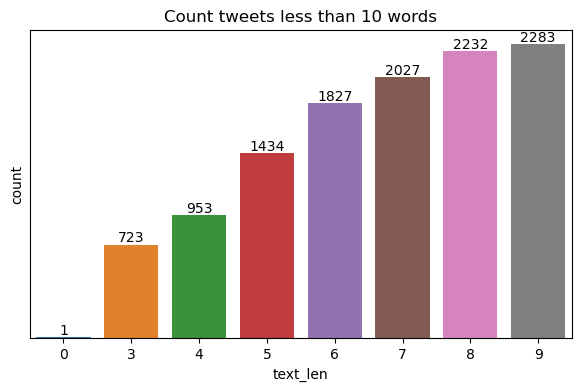

In [49]:
plt.figure(figsize=(7,4))
ax = sns.countplot(x='text_len', data=df[df['text_len'] < 10])
plt.title('Count tweets less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.show()

In [50]:
df.sort_values(by=['text_len'], ascending=False)

,text,sentiment,text_clean,text_len
44035,You so black and white trying to live like a n...,ethnicity,black white trying live like nigger pahahahaha...,173
45165,"@hermdiggz: “@tayyoung_: FUCK OBAMA, dumb ass ...",ethnicity,fuck obama dumb as nigger bitch ltthis whore s...,151
1317,@EurekAlertAAAS: Researchers push to import to...,not_cyberbullying,researcher push import top antibullying progra...,138
33724,"... I don't feel guilty for killing him, I jus...",age,feel guilty killing feel guilty enjoyed tormen...,136
10922,don't make rape jokes!!! don't make gay jokes!...,gender,make rape joke make gay joke oh fat joke okay ...,121
...,...,...,...,...
7499,and they say she's in the class A team.,not_cyberbullying,say class team,3
1282,@ChuckPfarrer @ParaKeta Beautiful map Chuck.,not_cyberbullying,beautiful map chuck,3
1278,Reading about crack #wow,not_cyberbullying,reading crack wow,3
4979,@JiaqiLeong ): you good. Everytime bully me!!!,not_cyberbullying,good everytime bully,3


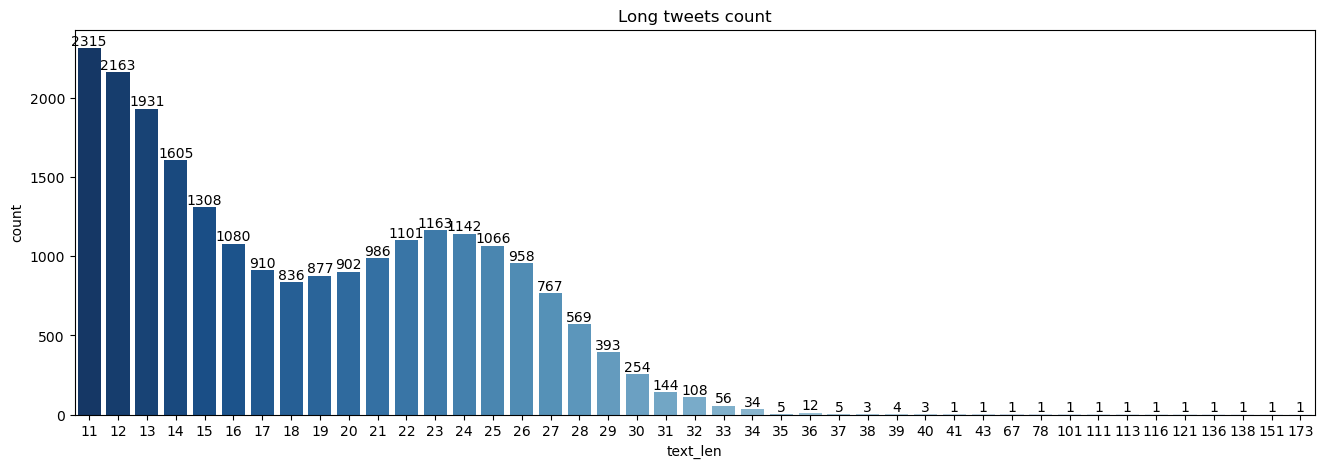

In [51]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=df[(df['text_len']<=1000) & (df['text_len']>10)], palette='Blues_r')
plt.title('Long tweets count')
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.show()

In [52]:
#remove too long tweet
df = df[df['text_len'] < df['text_len'].quantile(0.995)]

In [53]:
max_len = np.max(df['text_len'])
max_len

31

In [54]:
df.sort_values(by=['text_len'], ascending=False)

,text,sentiment,text_clean,text_len
8025,-TW- My aunt's boyfriend showed up to Thanksgi...,gender,tw aunt boyfriend showed thanksgiving dinner t...,31
8393,"#LGBTIQ proven RAPE JOKE CULTURED, led by RAIN...",gender,lgbtiq proven rape joke cultured led rainbow a...,31
22209,I think everyone know God and Allah is same. e...,religion,think everyone know god allah even qoran say s...,31
11849,"Nt another joke abt rape n prison systems,it’s...",gender,nt another joke rape prison systemsit high tym...,31
32065,Real shit!!! Yo i bought all black knee high c...,age,real shit yo bought black knee high converse a...,31
...,...,...,...,...
9460,@MechaSauce @shoe0nhead ...you have an armpit ...,gender,armpit licking fetish,3
1177,No more school for today lol,not_cyberbullying,school today lol,3
4591,@cheeseplus I typo crazy with browns,not_cyberbullying,typo crazy brown,3
6441,@Bruciebabe @MaxBlumenthal Here is the big pic...,not_cyberbullying,big picture microbrain,3


In [55]:
#ordinal encoding
df['sentiment'] = df['sentiment'].replace({'religion':0, 'age':1, 'ethnicity':2, 'gender':3, 'not_cyberbullying':4})

In [56]:
X = df['text_clean']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [57]:
np.unique(y_train, return_counts=True)


(array([0, 1, 2, 3, 4], dtype=int64),
 array([6267, 6209, 5879, 5784, 4853], dtype=int64))

In [58]:
#imbalance data, should oversampling

ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1,1), np.array(y_train).reshape(-1,1))
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['text_clean', 'sentiment'])

In [59]:
X_train = train_os['text_clean'].values
y_train = train_os['sentiment'].values

In [60]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int64),
 array([6267, 6267, 6267, 6267, 6267], dtype=int64))

In [61]:
clf = CountVectorizer()
X_train_cv = clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [62]:
nb_clf = MultinomialNB()
nb_clf.fit(X_train_tf, y_train)

MultinomialNB()

In [63]:
nb_pred = nb_clf.predict(X_test_tf)
print(classification_report(y_test, nb_pred, target_names=sentiments))
#f1 score low in not bullying

              precision    recall  f1-score   support

    religion       0.86      0.96      0.91      1567
         age       0.81      0.98      0.89      1552
   ethnicity       0.90      0.92      0.91      1470
      gender       0.89      0.87      0.88      1446
not bullying       0.82      0.49      0.62      1214

    accuracy                           0.86      7249
   macro avg       0.86      0.84      0.84      7249
weighted avg       0.86      0.86      0.85      7249



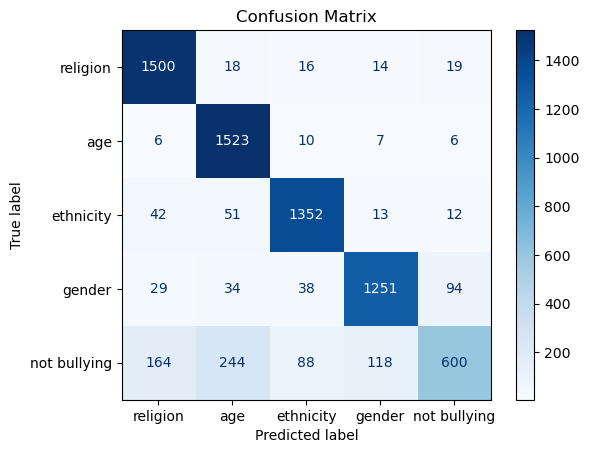

In [64]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

sentiments = ['religion', 'age', 'ethnicity', 'gender', 'not bullying']

cm = confusion_matrix(y_test, nb_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sentiments)
cm_display.plot(cmap='Blues', values_format='d') 
plt.title('Confusion Matrix')
plt.show()


# LSTM

In [65]:
# Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec

#for lstm need tokenize, create vocabulary
def Tokenize(column, seq_len):
    corpus = [word for text in column for word in text.split()]
    count_words = Counter(corpus)
    sorted_words = count_words.most_common()
    vocab_to_int = {w: index + 1 for index, (w, c) in enumerate(sorted_words)}

    text_int = []
    for text in column:
        temp = [vocab_to_int[word] for word in text.split()]
        text_int.append(temp)
    
    features = np.zeros((len(text_int), seq_len), dtype=int)

    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[:seq_len]
        features[i, :] = np.array(new)
    
    return sorted_words, features
    

# texts = ["this is a sample text", "this text is another example", "sample text for testing"]
# seq_len = 10
# sorted_words, padded_texts = Tokenize(texts, seq_len)

# # Display results
# print("Sorted Words:", sorted_words)
# print("Padded Texts:\n", padded_texts)
    


In [84]:
texts = ["this is a sample text", "this text is another example", "sample text for testing"]
seq_len = 10
sorted_words, padded_texts = Tokenize(texts, seq_len)

# Display example results
print("Sorted Words:", sorted_words)
print("Padded Texts:\n", padded_texts)

Sorted Words: [('text', 3), ('this', 2), ('is', 2), ('sample', 2), ('a', 1), ('another', 1), ('example', 1), ('for', 1), ('testing', 1)]
Padded Texts:
 [[0 0 0 0 0 2 3 5 4 1]
 [0 0 0 0 0 2 1 3 6 7]
 [0 0 0 0 0 0 4 1 8 9]]


In [66]:
vocabulary, tokenize_column = Tokenize(df['text_clean'], max_len)

In [86]:
tokenize_column[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,    85,
        2224,   563, 15529,    29])

In [83]:
df['text_clean'][0]

'word katandandre food crapilicious mkr'

In [81]:
keys = []
values = []
for key, value in vocabulary[:10]:
    print(key, ' ', value)
    keys.append(key)
    values.append(value)

school   8858
fuck   5347
girl   5345
like   5278
nigger   5060
joke   5013
high   4925
people   4902
dumb   4767
muslim   4673


c:\ProgramData\anaconda3\envs\PythonIlmuData1\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


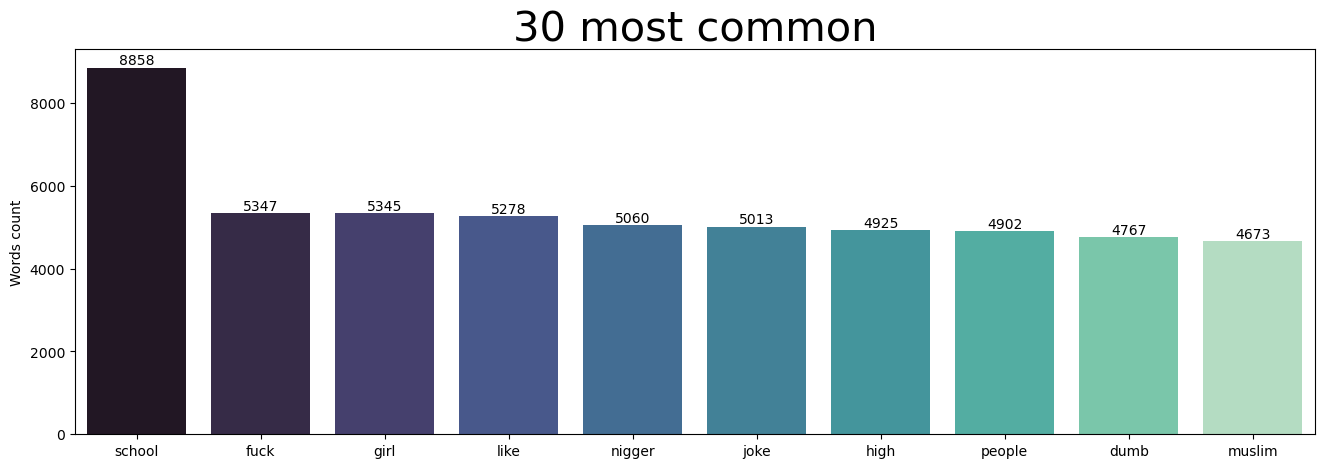

In [82]:
plt.figure(figsize=(16,5))
ax = sns.barplot(x=keys, y=values, palette='mako')
plt.title('30 most common', size=30)
ax.bar_label(ax.containers[0])
plt.ylabel('Words count')
plt.show()

In [93]:
Word2vec_train_data = list(map(lambda x:x.split(), X_train))

In [94]:
EMBEDDING_DIM = 300
word2vec_model = Word2Vec(Word2vec_train_data, vector_size=EMBEDDING_DIM)

In [95]:
print(len(vocabulary))

37591


In [96]:
VOCAB_SIZE = len(vocabulary) + 1

embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

for word, token in vocabulary:
    if word in word2vec_model.wv.key_to_index:
        embedding_vector = word2vec_model.wv[word]
        embedding_matrix[token] = embedding_vector
print('Embedding matrix shape ', embedding_matrix.shape)

Embedding matrix shape  (37592, 300)


In [103]:
X = tokenize_column
y = df['sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

In [104]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5014],
       [   1, 4967],
       [   2, 4703],
       [   3, 4627],
       [   4, 3882]], dtype=int64)

In [105]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train), np.array(y_train))

In [106]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5014],
       [   1, 5014],
       [   2, 5014],
       [   3, 5014],
       [   4, 5014]], dtype=int64)

In [107]:
train_data = TensorDataset(torch.from_numpy(X_train_os), torch.from_numpy(y_train_os))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

In [108]:
BATCH_SIZE = 32
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

In [110]:
import torch
import torch.nn as nn

class Attention(nn.Module):
    def __init__(self, hidden_dim, is_bidirectional):
        super(Attention, self).__init__()
        self.is_bidirectional = is_bidirectional
        self.hidden_dim = hidden_dim
        # The attention linear layer which transforms the input data to the hidden space
        self.attn = nn.Linear(hidden_dim * (2 if is_bidirectional else 1) * 2, hidden_dim * (2 if is_bidirectional else 1))
        # The linear layer that calculates the attention scores
        self.v = nn.Linear(hidden_dim * (2 if is_bidirectional else 1), 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        seq_len = encoder_outputs.size(1)
        # Concatenate the last two hidden states in case of a bidirectional LSTM
        if self.is_bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=-1)
        else:
            hidden = hidden[-1]
        # Repeat the hidden state across the sequence length
        hidden_repeated = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        # Calculate attention weights
        attn_weights = torch.tanh(self.attn(torch.cat((hidden_repeated, encoder_outputs), dim=2)))
        # Compute attention scores
        attn_weights = self.v(attn_weights).squeeze(2)
        # Apply softmax to get valid probabilities
        return nn.functional.softmax(attn_weights, dim=1)


class LSTM_Sentiment_Classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, dropout, is_bidirectional):
        super(LSTM_Sentiment_Classifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = lstm_layers
        self.is_bidirectional = is_bidirectional

        # The Embedding layer that converts input words to embeddings
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM layer which processes the embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, lstm_layers, batch_first=True, bidirectional=is_bidirectional)
        # Attention layer to compute the context vector
        self.attention = Attention(hidden_dim, is_bidirectional)
        # Fully connected layer which classifies the context vector into classes
        self.fc = nn.Linear(hidden_dim * (2 if is_bidirectional else 1), num_classes)
        # Apply LogSoftmax to outputs for numerical stability
        self.softmax = nn.LogSoftmax(dim=1)
        # Dropout layer for regularisation
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden):
        # Transform words to embeddings
        embedded = self.embedding(x)
        # Apply dropout to embeddings
        embedded = self.dropout(embedded)
        # Pass embeddings to LSTM
        out, hidden = self.lstm(embedded, hidden)
        # Apply dropout to LSTM output
        out = self.dropout(out)
        # Calculate attention weights
        attn_weights = self.attention(hidden[0], out)
        # Calculate context vector by taking the weighted sum of LSTM outputs
        context = attn_weights.unsqueeze(1).bmm(out).squeeze(1)
        # Apply dropout to context vector
        context = self.dropout(context)
        # Classify the context vector
        out = self.softmax(self.fc(context))
        return out, hidden

    def init_hidden(self, batch_size):
        # Factor determines the size of hidden states depending on bidirectionality
        factor = 2 if self.is_bidirectional else 1
        # Initial hidden and cell states are zero
        h0 = torch.zeros(self.num_layers * factor, batch_size, self.hidden_dim).to(DEVICE)
        c0 = torch.zeros(self.num_layers * factor, batch_size, self.hidden_dim).to(DEVICE)
        return h0, c0


In [111]:
NUM_CLASSES = 5 #We are dealing with a multiclass classification of 5 classes
HIDDEN_DIM = 100 #number of neurons of the internal state (internal neural network in the LSTM)
LSTM_LAYERS = 1 #Number of stacked LSTM layers

IS_BIDIRECTIONAL = False # Set this to False for unidirectional LSTM, and True for bidirectional LSTM

LR = 4e-4 #Learning rate
DROPOUT = 0.5 #LSTM Dropout
EPOCHS = 10 #Number of training epoch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = LSTM_Sentiment_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES, LSTM_LAYERS, DROPOUT, IS_BIDIRECTIONAL)

model = model.to(DEVICE)

# Initialize the embedding layer with the previously defined embedding matrix
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
# Allow the embedding matrix to be fine-tuned to better adapt to our dataset and get higher accuracy
model.embedding.weight.requires_grad = True

# Set up the criterion (loss function)
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay = 5e-6)

print(model)

LSTM_Sentiment_Classifier(
  (embedding): Embedding(37592, 300)
  (lstm): LSTM(300, 100, batch_first=True)
  (attention): Attention(
    (attn): Linear(in_features=200, out_features=100, bias=True)
    (v): Linear(in_features=100, out_features=1, bias=False)
  )
  (fc): Linear(in_features=100, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [112]:
total_step = len(train_loader)
total_step_val = len(valid_loader)

early_stopping_patience = 4
early_stopping_counter = 0

valid_acc_max = 0 # Initialize best accuracy top 0

for e in range(EPOCHS):

    #lists to host the train and validation losses of every batch for each epoch
    train_loss, valid_loss  = [], []
    #lists to host the train and validation accuracy of every batch for each epoch
    train_acc, valid_acc  = [], []

    #lists to host the train and validation predictions of every batch for each epoch
    y_train_list, y_val_list = [], []

    #initalize number of total and correctly classified texts during training and validation
    correct, correct_val = 0, 0
    total, total_val = 0, 0
    running_loss, running_loss_val = 0, 0


    ####TRAINING LOOP####

    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE) #load features and targets in device

        h = model.init_hidden(labels.size(0))

        model.zero_grad() #reset gradients

        output, h = model(inputs,h) #get output and hidden states from LSTM network

        loss = criterion(output, labels)
        loss.backward()

        running_loss += loss.item()

        optimizer.step()

        y_pred_train = torch.argmax(output, dim=1) #get tensor of predicted values on the training set
        y_train_list.extend(y_pred_train.squeeze().tolist()) #transform tensor to list and the values to the list

        correct += torch.sum(y_pred_train==labels).item() #count correctly classified texts per batch
        total += labels.size(0) #count total texts per batch

    train_loss.append(running_loss / total_step)
    train_acc.append(100 * correct / total)

    ####VALIDATION LOOP####

    with torch.no_grad():

        model.eval()

        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            val_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, val_h)

            val_loss = criterion(output, labels)
            running_loss_val += val_loss.item()

            y_pred_val = torch.argmax(output, dim=1)
            y_val_list.extend(y_pred_val.squeeze().tolist())

            correct_val += torch.sum(y_pred_val==labels).item()
            total_val += labels.size(0)

        valid_loss.append(running_loss_val / total_step_val)
        valid_acc.append(100 * correct_val / total_val)

    #Save model if validation accuracy increases
    if np.mean(valid_acc) >= valid_acc_max:
        torch.save(model.state_dict(), './state_dict.pt')
        print(f'Epoch {e+1}:Validation accuracy increased ({valid_acc_max:.6f} --> {np.mean(valid_acc):.6f}).  Saving model ...')
        valid_acc_max = np.mean(valid_acc)
        early_stopping_counter=0 #reset counter if validation accuracy increases
    else:
        print(f'Epoch {e+1}:Validation accuracy did not increase')
        early_stopping_counter+=1 #increase counter if validation accuracy does not increase

    if early_stopping_counter > early_stopping_patience:
        print('Early stopped at epoch :', e+1)
        break

    print(f'\tTrain_loss : {np.mean(train_loss):.4f} Val_loss : {np.mean(valid_loss):.4f}')
    print(f'\tTrain_acc : {np.mean(train_acc):.3f}% Val_acc : {np.mean(valid_acc):.3f}%')

Epoch 1:Validation accuracy increased (0.000000 --> 92.161602).  Saving model ...
	Train_loss : 0.7061 Val_loss : 0.2514
	Train_acc : 73.607% Val_acc : 92.162%
Epoch 2:Validation accuracy increased (92.161602 --> 93.059392).  Saving model ...
	Train_loss : 0.2368 Val_loss : 0.2167
	Train_acc : 92.605% Val_acc : 93.059%
Epoch 3:Validation accuracy did not increase
	Train_loss : 0.1638 Val_loss : 0.2206
	Train_acc : 94.875% Val_acc : 92.852%
Epoch 4:Validation accuracy did not increase
	Train_loss : 0.1136 Val_loss : 0.2420
	Train_acc : 96.644% Val_acc : 92.403%
Epoch 5:Validation accuracy did not increase
	Train_loss : 0.0793 Val_loss : 0.2795
	Train_acc : 97.765% Val_acc : 91.954%
Epoch 6:Validation accuracy did not increase
	Train_loss : 0.0576 Val_loss : 0.2961
	Train_acc : 98.380% Val_acc : 92.006%
Epoch 7:Validation accuracy did not increase
Early stopped at epoch : 7


In [113]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict.pt'))

<All keys matched successfully>

In [114]:
def evaluate_model(model, test_loader):
    model.eval()
    y_pred_list = []
    y_test_list = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            test_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, test_h)
            y_pred_test = torch.argmax(output, dim=1)
            y_pred_list.extend(y_pred_test.squeeze().tolist())
            y_test_list.extend(labels.squeeze().tolist())

    return y_pred_list, y_test_list

y_pred_list, y_test_list = evaluate_model(model, test_loader)

In [115]:
print('Classification Report for Bi-LSTM :\n', classification_report(y_test_list, y_pred_list, target_names=sentiments))

Classification Report for Bi-LSTM :
               precision    recall  f1-score   support

    religion       0.96      0.94      0.95      1564
         age       0.99      0.97      0.98      1548
   ethnicity       0.98      0.97      0.98      1463
      gender       0.92      0.90      0.91      1443
not bullying       0.79      0.87      0.83      1214

    accuracy                           0.93      7232
   macro avg       0.93      0.93      0.93      7232
weighted avg       0.93      0.93      0.93      7232



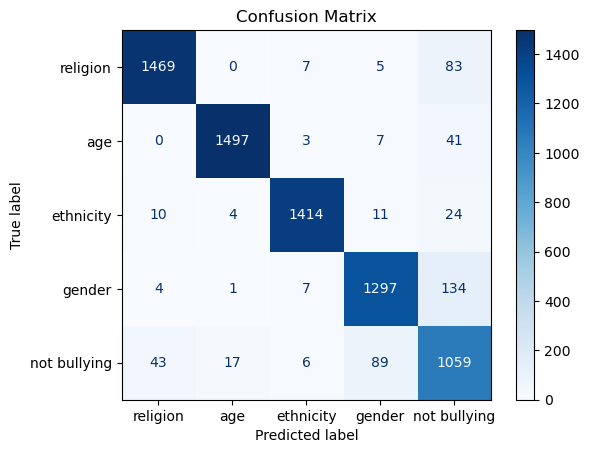

In [119]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

sentiments = ['religion', 'age', 'ethnicity', 'gender', 'not bullying']

cm = confusion_matrix(y_test_list, y_pred_list)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sentiments)
cm_display.plot(cmap='Blues', values_format='d') 
plt.title('Confusion Matrix')
plt.show()


In [ ]:
#LSTM give good result
#now use BERT
